## Apply NMO correction on synthetic data shots ##

###First on a cmp gather then on the entire set ###

For a given layered earth with $N$ layers with interval velocities given by:

$$ v_i = [ v_0, v_1, v_2, v_3 ... v_n] $$

And likewise with thickness given by:

$$ d_i = [ d_0, d_1, d_2, d_3 ... d_n] $$

The root mean square velocity at the $i$th layer down in the earth is given by:

\begin{equation*} V^2_{{rms}_i} = \frac{1}{\left(\sum_{j=0}^i \Delta t_j \right)}   \sum_{j=0}^i v_j^2 \Delta t_j \end{equation*}

Where the two way time $\Delta t_j$ :

$$ \Delta t_j = 2\frac{v_j}{d_j} $$

*For a horizontal stratified earth the $V_{rms}$ is equal the $V_{nmo}$ for any layer for a small spread aproximation
(offset small compared to depth).*

So the hyperbolic normal moveout correction for a  $i$th layer is given by:

$$ t_i^2 = t_{0_i}^2 + \frac{x^2}{V_{{rms}_i}^2} $$


*Oz Yilmaz p. 280
Seismic Data Analysis
Chapter 3*

In [1]:
def vrms(vi, ds):
    """
    Calculate RMS velocity from:

    * vi : ndarray
        interval velocity
    * ds : ndarray
        layer size
    
    return Rms velocity array
    """
    twt = 2*(ds/vi) # two way time
    vi2_twt = (vi**2)*twt
    return np.sqrt(vi2_twt.cumsum()/twt.cumsum())    

###Paraná Basin simple test example ###

Considering the thickness of the Serra-Geral formation varying from 300 to 1300 meters, basalt lava-flows.

What could we expect in the RMS velocity just bellow it. A reversal?

*Also plots the original interval velocity.*

I migth try get real well data to this.


In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


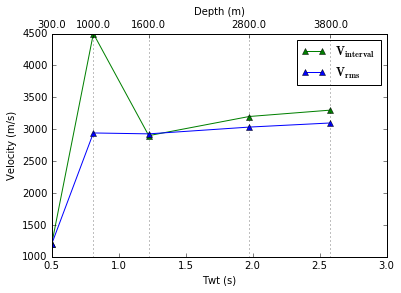

In [3]:
from matplotlib import pylab as pyplot
import numpy as np
# vrms calculation from intervalar velocity and
# layer size (Parana basin case 1300 meters)
vi = np.array([ 1200.0, 4500.0, 2900.0, 3200, 3300 ])
ds = np.array([ 300.0, 700.0, 600.0, 1200, 1000 ])    
v_rms = vrms(vi, ds)
twt = 2*(ds/vi) # two way time
fig = pyplot.figure()
ax = fig.add_subplot(111)
ax.plot(twt.cumsum(), vi, 'g-^', label=r'$\mathbf{V_{interval}}$')
ax.plot(twt.cumsum(), v_rms, 'b-^', label=r'$\mathbf{V_{rms}}$')
ax.set_xlabel("Twt (s)")
ax.set_ylabel("Velocity (m/s)")
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(twt.cumsum())
ax2.set_xticklabels(ds.cumsum())
ax2.xaxis.grid()
ax2.set_xlabel("Depth (m)")
ax.legend()

##NMO correction##

### Loading results from a previous simulation ###

**Dsource** = **Dstations** = 100.0 m = 2*dx

> ***!!Stack array shotting between stations!!***

> Excelent for stack supression of multiples / surface waves

> Excelent for balanced cmps for pre stack migration

Starting shotting at x = 100*dx = 5000 m

Starting station at x = (100-1)*dx-2*dx*35 = 99*dx-70*dx = 29*dx = 1450 m

Difference bettwen shot and station first = 3550 (max offset)

Shotting 100 shots: Total number of traces 70 stations * 100 shots = 7000 traces


In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


###Fill in trace header information as a tupple###

A list of 7000 traces will have (x source coordinate, and its x coordinate) 

In [5]:
dx = 50.0 # from grid size
startx = 100*dx # 5000
htraces = [] # trace header shot x coordinate and station x coordinate
for i in xrange(100): # each shot
    sx = startx + 100*i  # 2*dx = 100 meters 
    for j in xrange(70): # each station
        htraces.append((sx, sx-3550+100*j)) # source and receiver coordinate for this trace

### Show the acquisition pattern ###

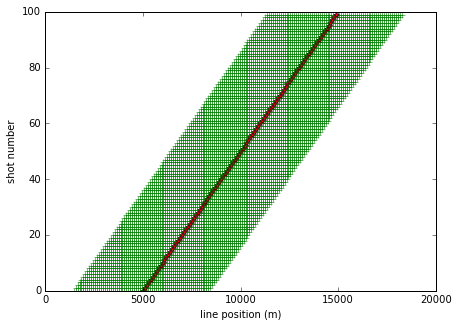

In [6]:
figure(figsize=(7,5))
for i in xrange(100):
    xstations = zip(*htraces[70*i:(70*(i+1))])[1]
    xsource = zip(*htraces[70*i:(70*(i+1))])[0][0]
    plot(xstations, [ i for j in range(70)], 'g+')  # stations
    plot(xsource, i, 'r*')  # source
ylabel("shot number")
xlabel("line position (m)")
pylab.show()

**1. Now calculate CMP and OFFSET trace header values**

**2. Create trace header values: xsource, xstation, cmp, offset**

Now It is a list of tuples 4 values (xsource, xstation, cmp, offset)



In [7]:
htraces[0] # first of 7000 traces

(5000.0, 1450.0)

In [8]:
htraces = [ (htraces[i][0], htraces[i][1], (htraces[i][0]+htraces[i][1])/2.,  
               abs(htraces[i][0]-htraces[i][1])) for i in range(7000) ]

In [9]:
htraces[0] # first of 7000 traces

(5000.0, 1450.0, 3225.0, 3550.0)

In [10]:
# (xsource, xstation, cmp, offset)
htraces[0:5] # first 25 of 7000 traces

[(5000.0, 1450.0, 3225.0, 3550.0),
 (5000.0, 1550.0, 3275.0, 3450.0),
 (5000.0, 1650.0, 3325.0, 3350.0),
 (5000.0, 1750.0, 3375.0, 3250.0),
 (5000.0, 1850.0, 3425.0, 3150.0)]

###Load the shots and merge with Trace Header information###

Creat the Traces[] list that is ([trace samples], htrace info]

In [11]:
%cd Fatiando
%cd ..

(bookmark:Fatiando) -> /home/andre/PycharmProjects/fatiando
/home/andre/PycharmProjects/fatiando
/home/andre/PycharmProjects


In [12]:
import numpy as np
shots = np.load('arrayshots_70s_900_01_11_2015.npy')
print shots.shape

(100, 900, 70)


In samples that is equal to 0.223078530146/0.00433034793813 ~~ 52 samples that will be removed of your simulation 

**So 52 samples needs to be removed. To make our data zero-phase!**

900-52 = 848 samples

In [13]:
dtraces = np.zeros((7000, 848))
p=0
for i in xrange(100):
    for j in xrange(70):
        dtraces[p, :] = shots[i, :848, j]
        p += 1

###For easier manipulation of traces based on headers we will use Pandas###

In [14]:
import pandas

tuple_traces = [((dtraces[i, :]), htraces[i][0], htraces[i][1], htraces[i][2], htraces[i][3]) for i in range(7000)]
df_traces = pandas.DataFrame(tuple_traces, columns=['traces', 'x_source', 'x_station', 'cmp', 'abs_offset'], 
                      dtype=np.float64)

### Plotting Fold Histogram ###

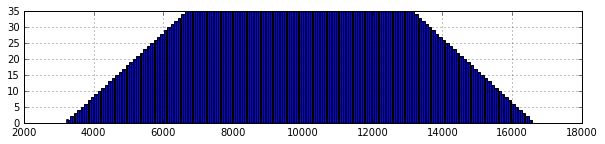

In [15]:
figure(figsize(10,2))
df_traces.cmp.hist(bins=df_traces.cmp.nunique())

###**Offset distribution in meters **###

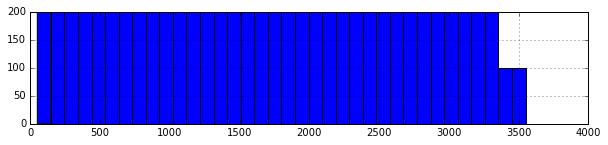

In [16]:
figure(figsize(10,2))
df_traces.abs_offset.hist(bins=df_traces.abs_offset.nunique())

Some unique CMPs.

The increment between CMPs is 100

In [17]:
print df_traces.cmp.unique()#[190:200]

[  3225.   3275.   3325.   3375.   3425.   3475.   3525.   3575.   3625.
   3675.   3725.   3775.   3825.   3875.   3925.   3975.   4025.   4075.
   4125.   4175.   4225.   4275.   4325.   4375.   4425.   4475.   4525.
   4575.   4625.   4675.   4725.   4775.   4825.   4875.   4925.   4975.
   5025.   5075.   5125.   5175.   5225.   5275.   5325.   5375.   5425.
   5475.   5525.   5575.   5625.   5675.   5725.   5775.   5825.   5875.
   5925.   5975.   6025.   6075.   6125.   6175.   6225.   6275.   6325.
   6375.   6425.   6475.   6525.   6575.   6625.   6675.   6725.   6775.
   6825.   6875.   6925.   6975.   7025.   7075.   7125.   7175.   7225.
   7275.   7325.   7375.   7425.   7475.   7525.   7575.   7625.   7675.
   7725.   7775.   7825.   7875.   7925.   7975.   8025.   8075.   8125.
   8175.   8225.   8275.   8325.   8375.   8425.   8475.   8525.   8575.
   8625.   8675.   8725.   8775.   8825.   8875.   8925.   8975.   9025.
   9075.   9125.   9175.   9225.   9275.   9325.   

###Get one CMP with full fold for example NMO Correction ###

**Like CMP 8625 **

In [18]:
CMPi = 8625
cmpn = df_traces[ df_traces['cmp'] == CMPi  ].traces.values
cmpnffsets =  df_traces[ df_traces['cmp'] == CMPi  ].abs_offset.values
cmpn = np.array([ cmpn[i] for i in range(size(cmpn)) ])
cmpn = cmpn.transpose()
print cmpn.shape

(848, 35)


Filter it removing simulation artifacts

Nyquest rate from simulation dt is

Fn = 1/(2*0.00433034793813) ~ 115

Then filtering to highest source frequency **fc = 9 Hz** would be:

(signal) High cut of lowpass ~ 0.078  niquest (divided by niquest 115Hz) for charity ~ 0.15

In [19]:
%cd Fatiando

(bookmark:Fatiando) -> /home/andre/PycharmProjects/fatiando
/home/andre/PycharmProjects/fatiando


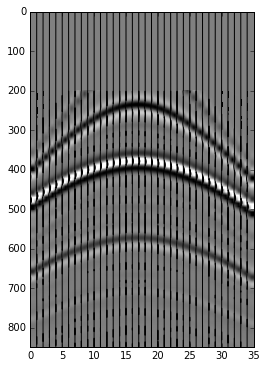

In [20]:
from scipy import signal
from fatiando.vis import mpl

sim_dt = 0.00433034793813

#Now create a lowpass Butterworth to lowpass the source frequency
fir = signal.firwin(527, 0.15)
for i in xrange(35):
    cmpn[:, i] = signal.convolve(cmpn[:, i], fir, 'same') # first must be the larger array
    
cmpn[:200,:] = 0.0 # gambiarra instead of fk for direct arrivals
figure(figsize=(4, 6), dpi=200)
dt = 0.00433034793813
mpl.seismic_image(cmpn, dt=1, vmin=-.001, vmax=0.001, aspect='auto')
mpl.seismic_wiggle(cmpn, dt=1, scale=100)

###Now lets get the aproximated NMO velocity function for this CMP ###

**From the simulated velocity model**

That corresponds to x index 

* 8625/50 = 172

From simulation:  **dx = 50**  **dz = 25**

Convert it to *RMS* velocity

In [21]:
%cd Fatiando
%cd ..

(bookmark:Fatiando) -> /home/andre/PycharmProjects/fatiando
/home/andre/PycharmProjects/fatiando
/home/andre/PycharmProjects


(160, 400)


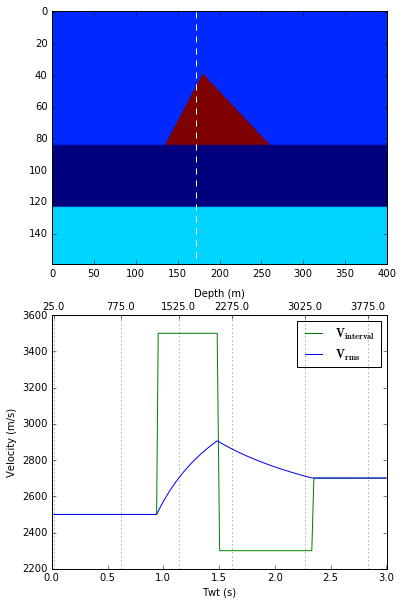

In [22]:
CMPi = 172

from PIL import Image
import numpy as np
from matplotlib import pylab

img = Image.open('wedge.tif')
img.load()
img = img.convert('I') # gray scale, convert format
vdata  = np.asarray(img, dtype=np.float32)
vdata[:][vdata[:] == 255.] = 2500.0 # overburden
vdata[:][vdata[:] == 0. ] = 3500 # the triangle
vdata[:][vdata[:] == 146.] = 2300.0 # the first slab bellow the triangle
vdata[:][vdata[:] == 36.] = 2700.0 # the last slab
vshape = vdata.shape
print vshape
figure(figsize=(6,10))
ax = pylab.subplot(211)
ax.plot([CMPi, CMPi], [0, 160], 'w--')
ax.imshow(vdata, aspect='auto')
#pylab.colorbar(ax, orientation='horizontal')

vi = vdata[:, CMPi]
ds = np.ones(160)*25
vrmsi = vrms(vi, ds)
twt = 2*(ds/vi) # two way time
twt = twt.cumsum()
ax = pylab.subplot(212)
ax.plot(twt, vi, 'g-', label=r'$\mathbf{V_{interval}}$')
ax.plot(twt, vrmsi, 'b-', label=r'$\mathbf{V_{rms}}$')
ax.set_xlabel("Twt (s)")
ax.set_ylabel("Velocity (m/s)")
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(twt[::30])
ax2.set_xticklabels(ds.cumsum()[::30])
ax2.xaxis.grid()
ax2.set_xlabel("Depth (m)")
ax.legend()

###** Resample the velocity function to same time sample rate of data (simulation dt)**### 


dt = 0.00433034793813

ns = 848 # number of samples


In [23]:
dt = sim_dt
ns = 848

from scipy.interpolate import UnivariateSpline as ispline
# linear with extrapolation possible, cubic is bad at end and start
fs = ispline(twt, vrmsi, bbox=[0.0, ns*dt], k=1) 
ntwt = np.linspace(0.0, ns*dt, ns)
svrmsi = fs(ntwt)

### Plot the velocity function over the cmp gather ###

### And finally NMO Correct it ###

Plot my velocity nmo functions then correct it

In [24]:
%cd Fatiando

(bookmark:Fatiando) -> /home/andre/PycharmProjects/fatiando
/home/andre/PycharmProjects/fatiando


(3.67213505153424, 0)

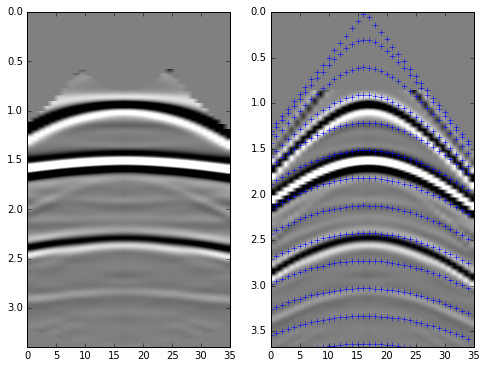

In [25]:
from fatiando.seismic import utils

figure(figsize(8,6))
pylab.subplot(121)
#svrmsi *= 0.92 # small tuning for better stacks, zero phase and shift problems 
# todo list mentioned before in shotting model
cmpnmo = utils.nmo(cmpn, cmpnffsets, svrmsi, dt=sim_dt)
mpl.seismic_image(cmpnmo, aspect='auto', vmin=-0.0005, vmax=0.0005)
#ylim(ns*sim_dt, 0)
pylab.subplot(122)
utils.plot_vnmo(cmpn, cmpnffsets, svrmsi, dt=sim_dt, vmin=-0.0005, vmax=0.0005)
ylim(ns*sim_dt, 0)
#mpl.seismic_wiggle(cmpnmo, scale=200)

###Apply NMO Correction in all cmp traces###

In [26]:
from scipy.interpolate import UnivariateSpline as ispline
from fatiando.seismic import utils

ds = np.ones(160)*25 # from dz = 25 simulation grid
dt = 0.00433034793813
ns = 848

ncmps = df_traces.cmp.nunique()
cmps = df_traces.cmp.unique()
cmps_stacked = np.zeros((ns, ncmps))

for i in xrange(ncmps):

    print(i)
    CMPi = cmps[i]
    df_cmp = df_traces[ df_traces['cmp'] == CMPi  ]
    cmpn = df_cmp.traces.values
    cmpnoffsets =  df_cmp.abs_offset.values
    cmpn = np.array([ cmpn[p] for p in range(size(cmpn)) ])
    cmpn = cmpn.transpose()
    
    vi = vdata[:, CMPi//50]  # interval velocity  
    vrmsi = utils.vrms(vi, ds) # rms velocity
    twt = 2*(ds/vi) # exact two way time from interval velocity
    twt = twt.cumsum() 
    # linear with extrapolation possible, cubic is bad at end and start
    ntwt = np.linspace(0.0, ns*dt, ns)
    svrms = fs(ntwt)        
    cmpn[:180, :] = 0.0 # mute all instead of fk for direct arrivals
    #svrms *= 0.92 # small tuning for better stacks
    cmp_nmo = utils.nmo(cmpn, cmpnoffsets, svrms*0.92, dt)   
    cmps_stacked[:, i] = cmp_nmo.sum(1) # stack all traces

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267


(bookmark:Fatiando) -> /home/andre/PycharmProjects/fatiando
/home/andre/PycharmProjects/fatiando


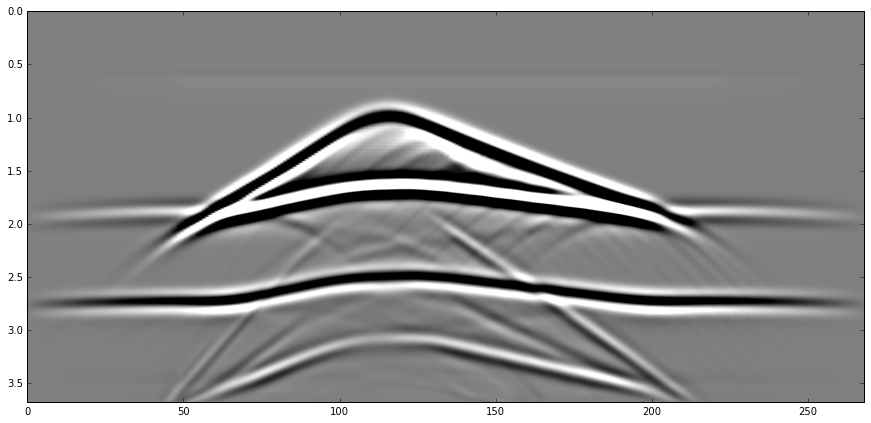

In [27]:
%cd Fatiando
from fatiando.vis import mpl

figure(figsize=(15,7))
mpl.seismic_image(cmps_stacked, dt=sim_dt, vmin=-.01, vmax=0.01, aspect='auto')
#mpl.seismic_wiggle(cmps_stacked, dt=sim_dt, scale=50)


In [28]:
np.save('cmp_stacked_01_12_2015', cmps_stacked)

In [29]:
cmps_stacked.shape

(848, 268)

For future work

In [ ]:
cmp8625fft = np.fft.fft2(cmp8625)
cmp8625fk = np.abs(cmp8625fft)
figure(figsize=(10, 10))
imshow(cmp8625fk[:int(917/2)][:], aspect=.8, extent=[0, 30, 0, 1./(2*dt)], origin='lower')
ylabel('frequency (Hz)')
xlabel('wave number (k)')
ylim([0., 50])

In [ ]:
%cd Fatiando
dt = 0.00433034793813

def apply_nmo(nmo_args, dt=dt):
    cmpn, cmpnffsets, svrmsi = nmo_args
    sim = wavefd.Scalar(velocity, (dx, dz))     
    sim.add_point_source((source_x, 0), wavefd.Gauss(1., fc))   
    sim.run(iter)
    return sim[:, 3, array_stations]

from multiprocessing import Pool
print('Simulating...')
pool = Pool()
shots = pool.map(rum_sim_shot, zip(shots_x, stations_x))
pool.close()
print('Finished')